In [1]:
import lyricsgenius # Python-based Genius API
import pandas as pd # For organizing data to analyze
import utils # For sanitization

# For lyrical analysis
import numpy as np
import nltk
from nltk.tokenize import word_tokenize
from nltk.sentiment.vader import SentimentIntensityAnalyzer 
from nltk.corpus import stopwords

analyser = SentimentIntensityAnalyzer()
stop_words = set(stopwords.words('english'))

# Import graphing tools
import matplotlib.pyplot as plt

# Ignore handful of words that aren't stopwords but should be
import warnings
warnings.filterwarnings('ignore')

In [2]:
def trim_songs(df, remix=False, unfinished=False):
    '''
    Remove songs from a list depending on user preference. Can remove remix songs or duplicate songs titles. 
    Note that for some artists, the majority of an album can be remixes. While removing them can drastically
    cut down on songs analyzed, keeping them will likely add repetitive results.

    Args:
        df : (DataFrame)
            dataframe containing all songs to consider
        remix=False : (bool)
            specifies whether or not remix songs should be removed
        unfinished=False : (bool)
            specifies whether or not "unfinished" songs should be removed
    '''
    if remix:
        df = remove_remix(df)
    if unfinished:
        df = remove_unfinished(df)
    
    return df

def remove_remix(df):
    remix_words = ['remix', 'alternate', 'cover', 'music video']
    songs_to_remove = [song for song in df.Song.values if any([remix_word in song.lower() \
                        for remix_word in remix_words]) and song.lower() not in remix_words]
    print('songs to remove: ', songs_to_remove)
    df = df.loc[~df.Song.isin(songs_to_remove)]

    return df

def remove_unfinished(df):
    unfinished_words = ['snippet', 'note', 'leak', 'demo']
    songs_to_remove = [song for song in df.Song.values if any([unfinished_word in song.lower() \
                        for unfinished_word in unfinished_words]) and song.lower() not in unfinished_words]
    print('songs to remove: ', songs_to_remove)
    df = df.loc[~df.Song.isin(songs_to_remove)]   
    return df

In [3]:
# User input
# Authenticate with Genius API, set conditions
genius = lyricsgenius.Genius(client_access_token=input('Please enter API key: '),remove_section_headers=True)
artist_to_search = input('Enter artist to search: ')

# Create artist (max_songs = -1 in order to be able to selectively add songs later on)
## Note: Want max_songs = 0 but bug causes all songs to be searched instead of none
artist = genius.search_artist(artist_to_search, sort="title")

Please enter API key: 2BwMnoTzh_ynSeF0sl9mdCuRjCxkwTh9CbIB92ziMuIw7lx81J982zgZQtOxA64V
Enter artist to search: oliver tre
Searching for songs by oliver tre...

Changing artist name to 'Oliver Tree'
Song 1: "ABC (Kryph Remix)"
Song 2: "Again And Again"
Song 3: "Alien Boy"
Song 4: "Alien Boy (Big Data Remix)"
Song 5: "All Bets Are Off"
Song 6: "All I Got"
Song 7: "All That"
Song 8: "All That x Alien Boy"
Song 9: "Amelie (the treemake)"
Song 10: "An Apology"
Song 11: "Artemecia"
Song 12: "Better Things*"
Song 13: "Bury Me Alive"
Song 14: "Cash Machine"
Song 15: "Cheapskate"
Song 16: "Circuits*"
Song 17: "Constant isolation"
Song 18: "Day Gone"
Song 19: "Deliberate Decisions"
Song 20: "Demons"
Song 21: "For Love I Come (Oliver Tree Bootleg)"
Song 22: "From Reds to Blues"
Song 23: "Fuck"
Song 24: "Fuck (Virtual Riot Remix)"
Song 25: "Gaining Momentum"
Song 26: "Gentle Giant"
Song 27: "Hall (the treemake)"
Song 28: "Hurt"
Song 29: "Hurt (NGHTMRE Remix)"
Song 30: "Hurt (RAC Mix)"
Song 31: "IA

In [4]:
# Create variables to store song info in format easy to work with
df = pd.DataFrame(columns=['Song', 'Album', 'Date', 'Lyrics'])

In [5]:
# Create dataframe with all necessary song info
for song in artist.songs[1:]:
    date = song.year if song.year is not None else np.nan
    df = df.append({'Song':song.title, 'Album':song.album, 'Date':date, 'Lyrics':song.lyrics}, ignore_index=True)

In [6]:
# Tokenize lyrics & remove stop words
df.Lyrics = df.Lyrics.apply(word_tokenize)
df.Lyrics = df.Lyrics.apply(lambda lyrics: [word for word in lyrics if word not in stop_words])

In [7]:
# Add num_words for each song in order to normalize sentiment
df['n_words'] = df['Lyrics'].apply(len)
df['compound'] = df['Lyrics'].apply(lambda lyrics: sum([analyser.polarity_scores(word)['compound'] for word in lyrics])) / df['n_words']
df['pos'] = df['Lyrics'].apply(lambda lyrics: sum([analyser.polarity_scores(word)['pos'] for word in lyrics])) / df['n_words']
df['neu'] = df['Lyrics'].apply(lambda lyrics: sum([analyser.polarity_scores(word)['neu'] for word in lyrics])) / df['n_words']
df['neg'] = df['Lyrics'].apply(lambda lyrics: sum([analyser.polarity_scores(word)['neg'] for word in lyrics])) / df['n_words']

In [8]:
# Assign all songs w/o album to 'noalbum' (at the time of writing, no album listed on genius has the title 'noalbum', so no issue is currently anticipated)
df['Album'] = df['Album'].apply(lambda title: 'noalbum' if title is None else title)

In [9]:
# Get user input for which albums to analyze
albums = sorted(set(df.Album.values))
for index, album in enumerate(albums):
    print('{}: {}'.format(index, album))
albums_to_analyze = input('Input number for each album to analyze, separated by a comma: ').split(',')
albums_to_analyze = [albums[int(i)] for i in albums_to_analyze]

0: 100 Greatest Workout Songs: Top Tracks for the Gym
1: Alien Boy
2: Demons
3: Do You Feel Me?
4: Splitting Branches
5: The World Around Me
6: Ugly Is Beautiful
7: noalbum
Input number for each album to analyze, separated by a comma: 1, 3


In [10]:
# Drop remixed songs 
df = trim_songs(df, remix=True, unfinished=True)

songs to remove:  ['Alien Boy (Big Data Remix)', 'Fuck (Virtual Riot Remix)', 'Hurt (NGHTMRE Remix)', 'Miracle Man (Zeds Dead Remix)']
songs to remove:  ['Demons']


,Song,Album,Date,Lyrics,n_words,compound,pos,neu,neg
0,Again And Again,Ugly Is Beautiful,2020-07-17,"[Lyrics, song, yet, released, ., Please, check...",11,0.028927,0.090909,0.727273,0.000000
1,Alien Boy,Ugly Is Beautiful,2018-02-16,"[I, fell, earth, From, hundred, miles, away, ,...",164,0.004027,0.042683,0.768293,0.024390
3,All Bets Are Off,Do You Feel Me?,2019-08-02,"[Tell, want, ,, need, Tell, wan, na, give, How...",200,-0.004859,0.060000,0.695000,0.075000
4,All I Got,Alien Boy,2017-05-26,"[Everything, I, lost, ,, baby, 're, I, got, Ev...",198,0.006830,0.030303,0.671717,0.015152
5,All That,Alien Boy,2018-02-16,"[Whoo, ,, okay, Like, ,, way, Quit, running, b...",244,-0.027050,0.086066,0.569672,0.127049
...,...,...,...,...,...,...,...,...,...
66,Upside Down,Alien Boy,2018-01-04,"[It, seems, sometimes, I, 'm, stuck, upside, A...",114,-0.040921,0.017544,0.561404,0.122807
67,Warrior,Splitting Branches,NaN,"[Warrior, ,, warrior, ,, warrior, ,, Warrior, ...",107,-0.014220,0.009346,0.710280,0.037383
68,Waste My Time,Ugly Is Beautiful,2020-07-17,"[I, wo, n't, waste, time, Why, whole, life, ,,...",290,-0.014545,0.017241,0.620690,0.079310
69,Welcome to LA,Alien Boy,2017-05-26,"[Baby, ,, 're, liar, Well, ,, maybe, I, 'm, li...",185,-0.068438,0.081081,0.632432,0.172973


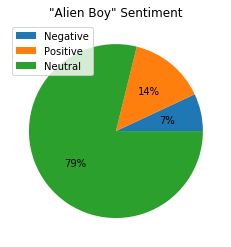

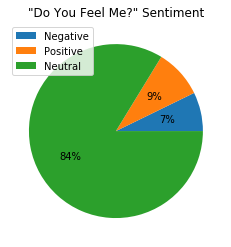

In [34]:
for album in albums_to_analyze:
    pos = df[df.Album == album].pos.sum()
    neg = df[df.Album == album].neg.sum()
    neu = df[df.Album == album].neu.sum()
    tot = pos + neg + neu
    
    plt.pie([pos / tot, neg / tot, neu / tot], autopct='%1.0f%%')
    plt.legend(['Negative', 'Positive', 'Neutral'])
    plt.title('"{}" Sentiment'.format(album))
    plt.show()
    #plt.savefig('../images/{}_pie_chart.png'.format(album))
    plt.close()